In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../data/JOAO PESSOA.csv")


In [3]:
data

,Data da Coleta,Produto,Valor de Venda
0,2018-12-30,GASOLINA,4.184500
1,2019-01-06,GASOLINA,4.063250
2,2019-01-13,GASOLINA,4.028167
3,2019-01-20,GASOLINA,3.952458
4,2019-01-27,GASOLINA,3.903375
...,...,...,...
309,2024-12-01,GASOLINA,5.861579
310,2024-12-08,GASOLINA,5.853684
311,2024-12-15,GASOLINA,5.841053
312,2024-12-22,GASOLINA,5.846842


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


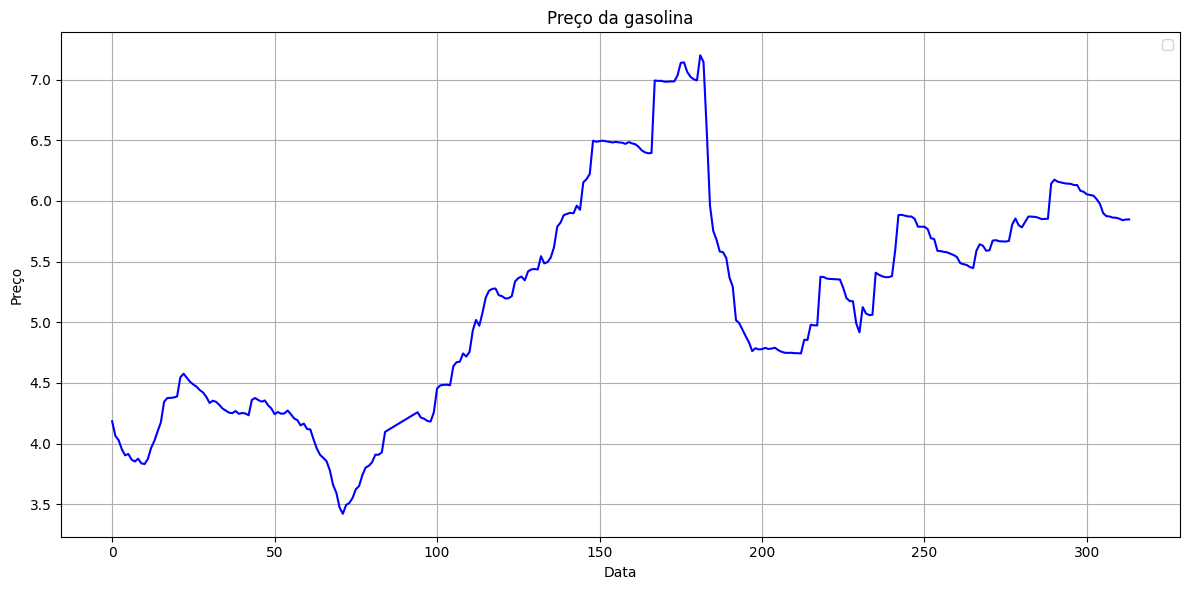

In [4]:

# Renomeando a coluna
data.rename(columns={'Valor de Venda': 'Valor_de_Venda'}, inplace=True)
data = data.drop(columns='Produto')


from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)

data['Valor_de_Venda'].interpolate(method='linear', inplace=True)  # Interpola linearmente


# Plotar valores reais e previstos para a cidade
plt.figure(figsize=(12,6))
plt.plot(data['Valor_de_Venda'],  color='blue')

# Títulos e legendas
plt.title('Preço da gasolina')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
data

,Data da Coleta,Valor_de_Venda
0,2018-12-30,4.184500
1,2019-01-06,4.063250
2,2019-01-13,4.028167
3,2019-01-20,3.952458
4,2019-01-27,3.903375
...,...,...
309,2024-12-01,5.861579
310,2024-12-08,5.853684
311,2024-12-15,5.841053
312,2024-12-22,5.846842


In [6]:
# Ordenar por tempo
data = data.sort_values("Data da Coleta")

# Criar variável lag1
data["lag1"] = data["Valor_de_Venda"].shift(1)
data = data.dropna()  # Remover primeira linha com NaN

# Divisão em treino e teste (80% treino, 20% teste)
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]



In [7]:
# Definir variáveis para treino
X_train = train_data["lag1"].values
y_train = train_data["Valor_de_Venda"].values

print("tamanho do conjunto de treinamento :",len(X_train))

tamanho do conjunto de treinamento : 250


In [8]:
# Obter os valores do conjunto de teste
X_test = test_data["lag1"].values
y_test = test_data["Valor_de_Venda"].values

print("tamanho do conjunto de teste:",len(X_test))

tamanho do conjunto de teste: 63


In [9]:
import pymc as pm
import numpy as np
import arviz as az

# Certifique-se de que X_train, y_train, X_test e y_test estão corretamente definidos
T_train = len(X_train)  # Número de observações de treino
T_test = len(X_test)    # Número de observações de teste

# Criando o modelo no PyMC
with pm.Model() as modelo_rw:
    sigma_mu = pm.HalfNormal("sigma_mu", sigma=1)  # Prior para a variância do passeio aleatório
    sigma = pm.HalfNormal("sigma", sigma=1)  # Prior para a variância do erro

    # Processo de passeio aleatório puro para modelar a tendência em y_train
    mu = pm.GaussianRandomWalk("mu", sigma=sigma_mu, shape=T_train)

    # Observações ligadas ao passeio aleatório
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_train)

    # Amostragem do modelo
    trace_rw = pm.sample(1000, tune=500, target_accept=0.7)

# Fazendo previsões para X_test
with modelo_rw:
    pm.set_data({"y_obs": y_train})  # Usar os dados de treino
    posterior_predictivo = pm.sample_posterior_predictive(trace_rw, var_names=["mu", "sigma"])

# Pegando os valores previstos para o conjunto de teste
mu_pred = posterior_predictivo.posterior_predictive["mu"].mean(dim=["chain", "draw"])[-T_test:]

# Visualizando os resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(T_train), y_train, label="Treino", color="blue")
plt.plot(range(T_train, T_train + T_test), y_test, label="Real (Teste)", color="green")
plt.plot(range(T_train, T_train + T_test), mu_pred, label="Previsão", color="red", linestyle="dashed")
plt.legend()
plt.xlabel("Tempo")
plt.ylabel("Valor de y")
plt.title("Previsão com Passeio Aleatório no PyMC")
plt.show()




WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\pymc\distributions\timeseries.py:297: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_mu, sigma, mu]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1957 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


TypeError: The variable `y_obs` must be a `SharedVariable` (created through `pm.Data()` to allow updating.) The current type is: <class 'pytensor.tensor.variable.TensorVariable'>

NameError: name 'y_pred' is not defined

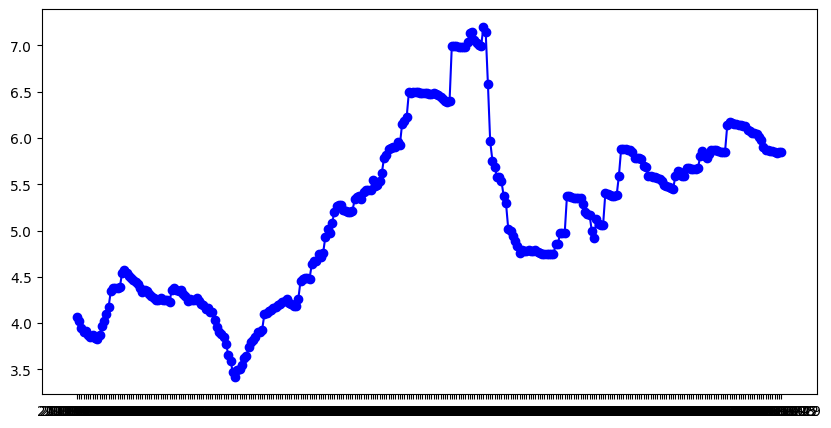

In [ ]:
import matplotlib.pyplot as plt

# Criar figura
plt.figure(figsize=(10, 5))

# Plotar os valores reais
plt.plot(data["Data da Coleta"], data["Valor_de_Venda"], label="Valores Reais", marker="o", color="blue")

# Plotar as previsões APENAS no conjunto de teste
plt.plot(test_data["Data da Coleta"], y_pred, label="Previsão (Teste)", linestyle="--", color="red", marker="x")

# Personalizar gráfico
plt.xlabel("Data")
plt.ylabel("Preço da Gasolina")
plt.title("Previsão do Preço da Gasolina (Teste)")
plt.legend()
plt.xticks(rotation=45) 
plt.grid()

# Mostrar gráfico
plt.show()

